# Demo Project Using Airflow and Docker to Ingest and Clean Data

Let's assume we have clients sending [hotel booking demand data](https://www.sciencedirect.com/science/article/pii/S2352340918315191) from multiple data sources to a scalable storage solution. Before analyzing the raw data, we need to clean it and then load it into a database where it can be accessed for analysis. For simplicity in our DAG example, we will work using local storage. Our Airflow DAG will have two tasks. First, the DAG will pick up the data from local storage, processes it, and load it into local storage. Secondly, the DAG will display a message once the data is successfully processed.

The basic flow of how Airflow is used:
![Airflow Diagram](https://dezyre.gumlet.io/images/blog/apache-airflow-data-pipeline-example/Apache_Airflow_Workflow.png?w=1100&dpr=1.0)

## Edit default docker-compose.yaml file:

Get `default docker-compose.yaml` file:

```bash
curl -LfO 'https://airflow.apache.org/docs/apache-airflow/2.3.3/docker-compose.yaml'
```

Add raw_data and processed_data volumes to `docker-compose.yaml`:

```
volumes:
    - ./dags:/opt/airflow/dags
    - ./logs:/opt/airflow/logs
    - ./plugins:/opt/airflow/plugins
    - ./raw_data:/opt/airflow/raw_data
    - ./processed_data:/opt/airflow/processed_data
```

Add user and group ID to .env file:
```
echo -e "AIRFLOW_UID=$(id -u)" > .env.
echo -e "AIRFLOW_GID=0" >> .env.
```

## Write python file for data cleaning:
```python
# Import libraries:
from datetime import timedelta #Required to calculate duration
import airflow #Required to instantiate a DAG
import pandas as pd
import numpy as np
import os

from airflow import DAG
from airflow.operators.python import PythonOperator #Python operator will be used in our task to run any Python code

dag_path = os.getcwd()

#Callable functions:
def data_cleaning():
    hotel_data = pd.read_csv("raw_data/hotel_bookings.csv") # Importing raw data
    hotel_data.head() # Display first 10 rows of data
    hotel_data.info() # Print info about dataframe
    hotel_data.describe() # Return description of data in dataframe
    
    # Checking null columns
    hotel_data.isnull().sum()
    
    # Replace missing values
    nan_replacements = {'children': 0, 'country':'Unknown', 'agent':'Organic Booking', 'company':'Personal Booking'}
    cleaned_data = hotel_data.fillna(nan_replacements)
    
    hotel_data.info()
    
    # Store cleaned data
    cleaned_data.to_csv('processed_data/processed_hotel_data.csv', index=False)
    
def cleaned_data_message():
    print('Data successfully cleaned')

# These arguments will be passed to each operator
default_args = {
    'owner': 'airflow',
    'depends_on_past': False,
    'start_date': airflow.utils.dates.days_ago(7) # Date which the DAG should start running
}

# Object to instantiate pipeline dynamically:
data_cleaning_dag = DAG(
    'data_cleaning_dag', # Name of the DAG displayed in airflow UI
    default_args = default_args,
    schedule_interval = timedelta(days=30), # Interval at which the DAG should run
    catchup = False
)

# Tasks:
clean_data = PythonOperator(
    task_id = 'data_cleaning',
    python_callable = data_cleaning,
    dag = data_cleaning_dag
)
          
message = PythonOperator(
    task_id = 'cleaned_data_message',
    python_callable = cleaned_data_message,
    dag = data_cleaning_dag
)
          
# Set dependencies:
clean_data >> message
```

## Run DAG in Airflow with Docker:

```bash
docker-compose up airflow-init
docker-compose up
```

Airflow Web UI when DAG is run successfully:
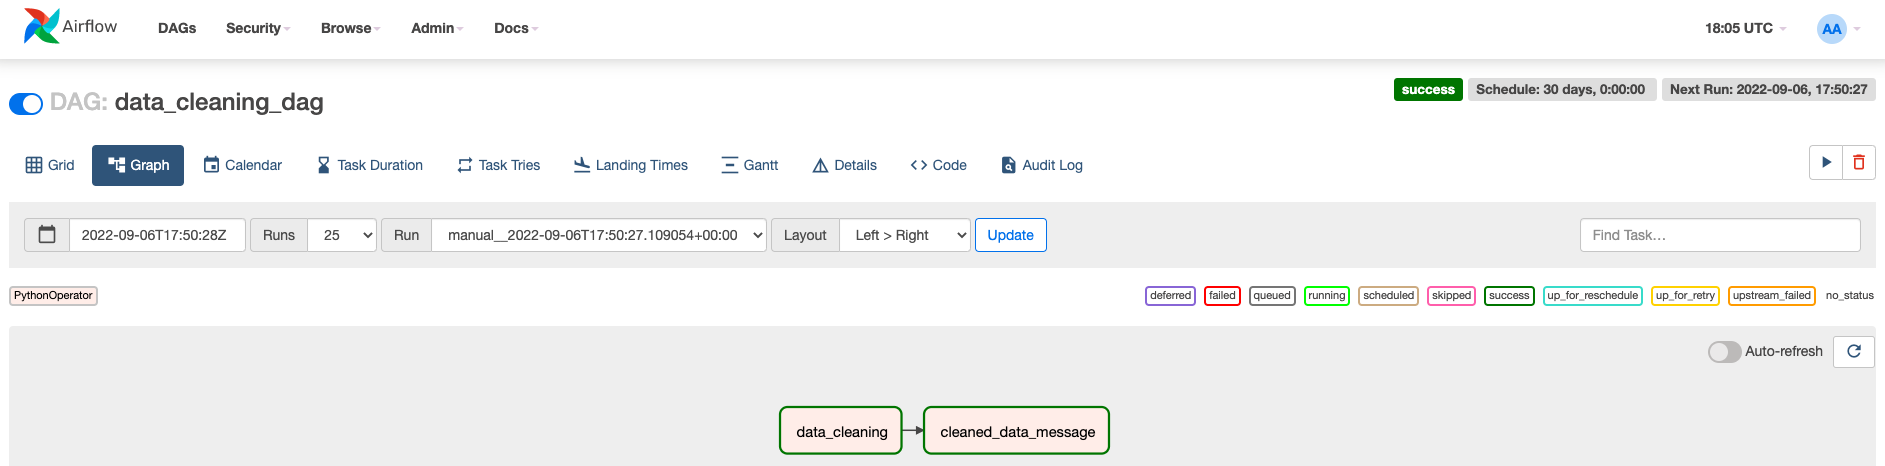

Check logs to see whether DAG was successful:
```
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   79330 non-null  int64  
 1   LeadTime                     79330 non-null  int64  
 2   ArrivalDateYear              79330 non-null  int64  
 3   ArrivalDateMonth             79330 non-null  object 
 4   ArrivalDateWeekNumber        79330 non-null  int64  
 5   ArrivalDateDayOfMonth        79330 non-null  int64  
 6   StaysInWeekendNights         79330 non-null  int64  
 7   StaysInWeekNights            79330 non-null  int64  
 8   Adults                       79330 non-null  int64  
 9   Children                     79326 non-null  float64
 10  Babies                       79330 non-null  int64  
 11  Meal                         79330 non-null  object 
 12  Country                      79306 non-null  object 
 13  MarketSegment                79330 non-null  object 
 14  DistributionChannel          79330 non-null  object 
 15  IsRepeatedGuest              79330 non-null  int64  
 16  PreviousCancellations        79330 non-null  int64  
 17  PreviousBookingsNotCanceled  79330 non-null  int64  
 18  ReservedRoomType             79330 non-null  object 
 19  AssignedRoomType             79330 non-null  object 
 20  BookingChanges               79330 non-null  int64  
 21  DepositType                  79330 non-null  object 
 22  Agent                        79330 non-null  object 
 23  Company                      79330 non-null  object 
 24  DaysInWaitingList            79330 non-null  int64  
 25  CustomerType                 79330 non-null  object 
 26  ADR                          79330 non-null  float64
 27  RequiredCarParkingSpaces     79330 non-null  int64  
 28  TotalOfSpecialRequests       79330 non-null  int64  
 29  ReservationStatus            79330 non-null  object 
 30  ReservationStatusDate        79330 non-null  object 
dtypes: float64(2), int64(16), object(13)
memory usage: 18.8+ MB
[2022-09-06 17:50:37,812] {python.py:173} INFO - Done. Returned value was: None
[2022-09-06 17:50:37,875] {taskinstance.py:1420} INFO - Marking task as SUCCESS. dag_id=data_cleaning_dag, task_id=data_cleaning, execution_date=20220906T175027, start_date=20220906T175029, end_date=20220906T175037
[2022-09-06 17:50:38,003] {local_task_job.py:156} INFO - Task exited with return code 0
[2022-09-06 17:50:38,068] {local_task_job.py:273} INFO - 1 downstream tasks scheduled from follow-on schedule check
```

## Stop Docker containers

In [1]:
# Convert this README to HTML
!jupyter nbconvert README-airflow-docker-demo.ipynb --to html --template classic

[NbConvertApp] Converting notebook README-airflow-docker-demo.ipynb to html
[NbConvertApp] Writing 401232 bytes to README-airflow-docker-demo.html
